In [121]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import os
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from pathlib import Path

DATA_PATH = Path("datasets/CMaps/")
images_dir = "images"

indexes = ['unit_number', 'time_cycles']
settings = ['setting_1', 'setting_2', 'setting_3']
sensors = ['s_{}'.format(i+1) for i in range(0,21)]
COLS = indexes + settings + sensors

In [122]:
Sensor_dictionary = {}
dict_list = [
    "Fan intake temperature (°R)",
    "Low-Pressure Compressor outlet temperature (°R)",
    "High-Pressure Compressor outlet temperature (°R)",
    "Low-Pressure Turbine outlet temperature (°R)",
    "Fan intake pressure (psia)",
    "Bypass-duct pressure (psia)",
    "High-Pressure Compressor outlet pressure (psia)",
    "Physical fan RPM",
    "Physical core RPM",
    "Engine pressure ratio (P50/P2)",
    "High-Pressure Compressor outlet static pressure (psia)",
    "Fuel flow to Ps30 ratio (pps/psia)",
    "Corrected fan RPM",
    "Corrected core RPM",
    "Bypass ratio",
    "Burner fuel-air ratio",
    "Bleed enthalpy",
    "Required fan RPM",
    "Required fan conversion RPM",
    "High-pressure turbine cooling airflow",
    "Low-pressure turbine cooling airflow"
]

Sensor_dictionary = {f's_{i+1}': sensor for i, sensor in enumerate(dict_list)}
Sensor_dictionary

def load_fd_dataset(dataset_id):

    train_file = DATA_PATH / f"train_FD00{dataset_id}.txt"
    test_file  = DATA_PATH / f"test_FD00{dataset_id}.txt"
    rul_file   = DATA_PATH / f"RUL_FD00{dataset_id}.txt"

    df_train = pd.read_csv(
        train_file,
        sep=r"\s+",        
        header=None,
        names=COLS,
        index_col=False
    )

    df_test = pd.read_csv(
        test_file,
        sep=r"\s+",
        header=None,
        names=COLS,
        index_col=False
    )

    df_rul = pd.read_csv(
        rul_file,
        sep=r"\s+",
        header=None,
        names=["RUL"],
        index_col=False
    )
    
    return df_train, df_test, df_rul

def add_train_rul(df_train):
    # Group by unit and get the max cycle of each engine
    max_cycle = df_train.groupby("unit_number")["time_cycles"].transform("max")
    # RUL = distance to max cycle
    df_train["RUL"] = max_cycle - df_train["time_cycles"]
    return df_train

def add_test_rul(df_test, df_rul):

    idx = df_test.groupby("unit_number")["time_cycles"].transform("max") == df_test["time_cycles"]
    final_test_rows = df_test[idx].copy().reset_index(drop=True)
    final_test_rows["RUL"] = df_rul["RUL"]
    
    return final_test_rows

In [123]:
datasets = {}  

for i in range(1, 5):
    
    df_train_raw, df_test_raw, df_rul = load_fd_dataset(i)
    df_train = add_train_rul(df_train_raw)
    df_test_final = add_test_rul(df_test_raw, df_rul)
    key = f"FD00{i}"
    datasets[key] = {
        "train":       df_train,   
        "test":        df_test_raw,
        "rul":         df_rul,
        "test_final":  df_test_final,
    }

# Gradient Boosting

In [124]:
""" from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Prepare features and target
df_fd001 = datasets["FD001"]["train"]
X = df_fd001.drop(columns=["unit_number", "time_cycles", "RUL"])
y = df_fd001["RUL"]

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train Gradient Boosting Regressor
gbr = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
gbr.fit(X_train, y_train)

# Make predictions
y_pred = gbr.predict(X_val)

# Evaluate
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print("RMSE:", rmse)
print("MAE:", mae)
print("R²:", r2)
 """

' from sklearn.ensemble import GradientBoostingRegressor\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score\n\n# Prepare features and target\ndf_fd001 = datasets["FD001"]["train"]\nX = df_fd001.drop(columns=["unit_number", "time_cycles", "RUL"])\ny = df_fd001["RUL"]\n\n# Split into training and validation sets\nX_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)\n\n# Initialize and train Gradient Boosting Regressor\ngbr = GradientBoostingRegressor(\n    n_estimators=200,\n    learning_rate=0.1,\n    max_depth=5,\n    random_state=42\n)\ngbr.fit(X_train, y_train)\n\n# Make predictions\ny_pred = gbr.predict(X_val)\n\n# Evaluate\nrmse = np.sqrt(mean_squared_error(y_val, y_pred))\nmae = mean_absolute_error(y_val, y_pred)\nr2 = r2_score(y_val, y_pred)\n\nprint("RMSE:", rmse)\nprint("MAE:", mae)\nprint("R²:", r2)\n '

This is the simplest gradient boost evulation with no added features or methods to see what it looks on basic.

In [125]:
""" from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Prepare features and target
df_fd001 = datasets["FD001"]["train"]

# Drop unnecessary columns
drop_cols = ["unit_number", "time_cycles", "RUL", "s_1", "s_5", "s_6", "s_10", "s_16", "s_18", "s_19"]
feature_cols = [col for col in df_fd001.columns if col not in drop_cols]
X = df_fd001[feature_cols]
y = df_fd001["RUL"]

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train Gradient Boosting Regressor
gbr = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
gbr.fit(X_train, y_train)

# Make predictions
y_pred = gbr.predict(X_val)

# Evaluate
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print("RMSE:", rmse)
print("MAE:", mae)
print("R²:", r2) """

' from sklearn.ensemble import GradientBoostingRegressor\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score\nimport numpy as np\n\n# Prepare features and target\ndf_fd001 = datasets["FD001"]["train"]\n\n# Drop unnecessary columns\ndrop_cols = ["unit_number", "time_cycles", "RUL", "s_1", "s_5", "s_6", "s_10", "s_16", "s_18", "s_19"]\nfeature_cols = [col for col in df_fd001.columns if col not in drop_cols]\nX = df_fd001[feature_cols]\ny = df_fd001["RUL"]\n\n# Split into training and validation sets\nX_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)\n\n# Initialize and train Gradient Boosting Regressor\ngbr = GradientBoostingRegressor(\n    n_estimators=200,\n    learning_rate=0.1,\n    max_depth=5,\n    random_state=42\n)\ngbr.fit(X_train, y_train)\n\n# Make predictions\ny_pred = gbr.predict(X_val)\n\n# Evaluate\nrmse = np.sqrt(mean_squared_error(y_val, y_pred))\nmae = 

After we do dropping some slightly unhelpful columns our values worsen somehow so it not may be best to not drop those columns.

In [126]:
""" from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np

# Prepare features and target
df_fd001 = datasets["FD001"]["train"]
X = df_fd001.drop(columns=["unit_number", "time_cycles", "RUL"])
y = df_fd001["RUL"]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize and train Gradient Boosting Regressor
gbr = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
gbr.fit(X_train, y_train)

# Make predictions
y_pred = gbr.predict(X_val)

# Evaluate
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print("RMSE:", rmse)
print("MAE:", mae)
print("R²:", r2)
 """

' from sklearn.ensemble import GradientBoostingRegressor\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score\nfrom sklearn.preprocessing import StandardScaler\nimport numpy as np\n\n# Prepare features and target\ndf_fd001 = datasets["FD001"]["train"]\nX = df_fd001.drop(columns=["unit_number", "time_cycles", "RUL"])\ny = df_fd001["RUL"]\n\n# Scale features\nscaler = StandardScaler()\nX_scaled = scaler.fit_transform(X)\n\n# Split into training and validation sets\nX_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)\n\n# Initialize and train Gradient Boosting Regressor\ngbr = GradientBoostingRegressor(\n    n_estimators=200,\n    learning_rate=0.1,\n    max_depth=5,\n    random_state=42\n)\ngbr.fit(X_train, y_train)\n\n# Make predictions\ny_pred = gbr.predict(X_val)\n\n# Evaluate\nrmse = np.sqrt(mean_squared_error(y_val, y_pred))\nmae = mean_absolute_error(y_val, y_p

We can see scaling helps with results so it will be used

In [127]:
""" import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import uniform, randint

# Prepare features and target
df_fd001 = datasets["FD001"]["train"]
X = df_fd001.drop(columns=["unit_number", "time_cycles", "RUL"])
y = df_fd001["RUL"]

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Gradient Boosting Regressor
gbr = GradientBoostingRegressor(random_state=42)

# Set up the hyperparameter search space
param_dist = {
    'n_estimators': randint(100, 1000),  # number of trees
    'learning_rate': uniform(0.01, 0.2),  # learning rate
    'max_depth': randint(3, 10),  # max depth of the trees
    'min_samples_split': randint(2, 10),  # min samples to split
    'min_samples_leaf': randint(1, 10),  # min samples to be at a leaf node
    'subsample': uniform(0.5, 0.5)  # fraction of samples to use for fitting each tree
}

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    gbr, param_distributions=param_dist, 
    n_iter=50,  # number of different combinations to try
    scoring='neg_mean_squared_error',  # use negative MSE for scoring (as lower is better)
    cv=5,  # 5-fold cross-validation
    verbose=1,  # print progress
    random_state=42,
    n_jobs=-1  # use all available cores for computation
)

# Run the RandomizedSearchCV
random_search.fit(X_train, y_train)

# Get the best model from the random search
best_gbr = random_search.best_estimator_

# Make predictions with the best model
y_pred = best_gbr.predict(X_val)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print("Best Hyperparameters:", random_search.best_params_)
print("RMSE:", rmse)
print("MAE:", mae)
print("R²:", r2)
 """

' import numpy as np\nimport pandas as pd\nfrom sklearn.ensemble import GradientBoostingRegressor\nfrom sklearn.model_selection import train_test_split, RandomizedSearchCV\nfrom sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score\nfrom scipy.stats import uniform, randint\n\n# Prepare features and target\ndf_fd001 = datasets["FD001"]["train"]\nX = df_fd001.drop(columns=["unit_number", "time_cycles", "RUL"])\ny = df_fd001["RUL"]\n\n# Split into training and validation sets\nX_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)\n\n# Initialize the Gradient Boosting Regressor\ngbr = GradientBoostingRegressor(random_state=42)\n\n# Set up the hyperparameter search space\nparam_dist = {\n    \'n_estimators\': randint(100, 1000),  # number of trees\n    \'learning_rate\': uniform(0.01, 0.2),  # learning rate\n    \'max_depth\': randint(3, 10),  # max depth of the trees\n    \'min_samples_split\': randint(2, 10),  # min samples to split\n  

This is used grid search to see best hyperparameters to see what values are best. Which with the best model resluts will be used on next part.

RMSE: 41.01073497313826
MAE: 29.34156323192828
R²: 0.6318766026617582


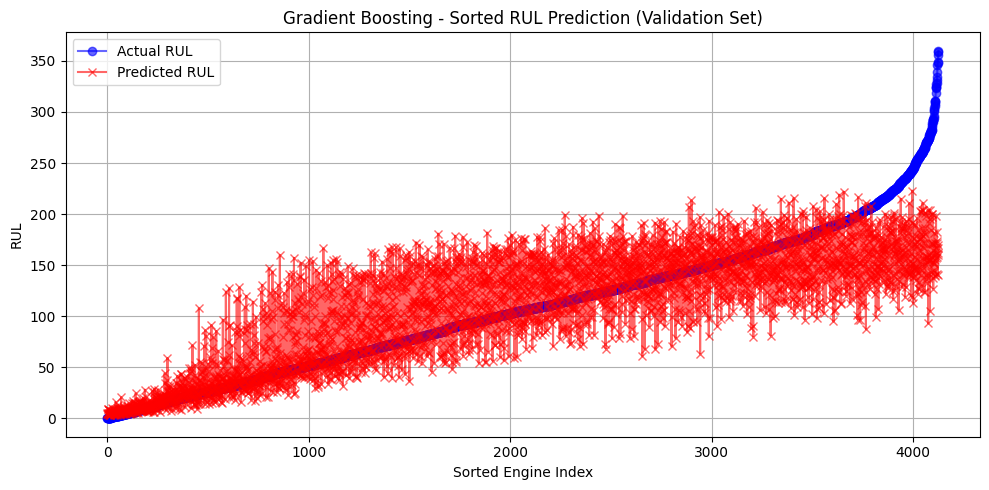

In [128]:
""" import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor

# Load dataset
df_fd001 = datasets["FD001"]["train"]

# Features and target
X = df_fd001.drop(columns=["unit_number", "time_cycles", "RUL"])
y = df_fd001["RUL"]

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize model with best found hyperparameters
gbr = GradientBoostingRegressor(
    learning_rate=0.010155753168202867,
    max_depth=6,
    min_samples_leaf=5,
    min_samples_split=2,
    n_estimators=559,
    subsample=0.8058265802441404,
    random_state=42
)

# Train model
gbr.fit(X_train, y_train)

# Predict
y_pred = gbr.predict(X_val)

# Evaluate
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print("RMSE:", rmse)
print("MAE:", mae)
print("R²:", r2)
 """
 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor

# Load dataset (assuming it's already loaded, as per the previous code)
df_fd001 = datasets["FD001"]["train"]  # Uncomment if not already loaded

# Features and target
X = df_fd001.drop(columns=["unit_number", "time_cycles", "RUL"])
y = df_fd001["RUL"]

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data without stratifying
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize model with best found hyperparameters
gbr = GradientBoostingRegressor(
    learning_rate=0.010155753168202867,
    max_depth=6,
    min_samples_leaf=5,
    min_samples_split=2,
    n_estimators=559,
    subsample=0.8058265802441404,
    random_state=42
)

# Train model
gbr.fit(X_train, y_train)

# Predict
y_pred = gbr.predict(X_val)

# Evaluate
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print("RMSE:", rmse)
print("MAE:", mae)
print("R²:", r2)

# Sort by true RUL
sorted_indices = np.argsort(y_val)  # Get the sorted indices of true RUL
y_true_sorted = y_val.iloc[sorted_indices]  # Sort actual RUL
y_pred_sorted = y_pred[sorted_indices]  # Sort predicted RUL based on true RUL

# Plot
plt.figure(figsize=(10, 5))
plt.plot(y_true_sorted.values, label='Actual RUL', marker='o', color='blue', alpha=0.6)
plt.plot(y_pred_sorted, label='Predicted RUL', marker='x', color='red', alpha=0.6)
plt.title("Gradient Boosting - Sorted RUL Prediction (Validation Set)")
plt.xlabel("Sorted Engine Index")
plt.ylabel("RUL")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




After using best hyperparameters we found on GridSearch and use Scaling combined we get best results yet

✅ Evaluation on the final engine cycle (corrected):
RMSE: 32.68597851518096
MAE: 23.841807053397446
R²: 0.3813237597703546

True RUL values (last cycle):
count    100.00000
mean      75.52000
std       41.76497
min        7.00000
25%       32.75000
50%       86.00000
75%      112.25000
max      145.00000
dtype: float64


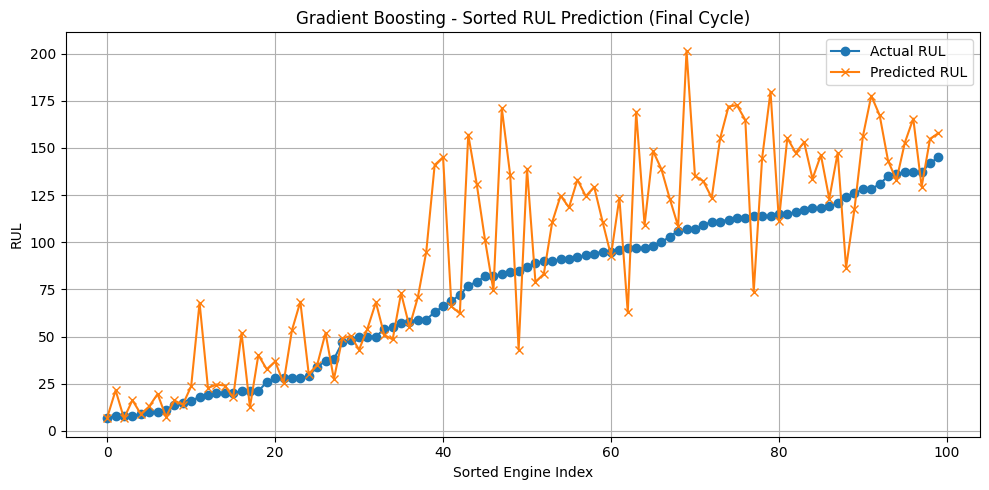

' # Line Plot of Actual vs Predicted RUL per engine (unit)\nplt.figure(figsize=(10, 5))\nplt.plot(y_true_final, label=\'Actual RUL\', marker=\'o\')\nplt.plot(y_pred_final, label=\'Predicted RUL\', marker=\'x\')\nplt.title("Gradient Boosting - RUL Prediction per Engine (Final Cycle Only)")\nplt.xlabel("Engine (unit_number)")\nplt.ylabel("RUL")\nplt.legend()\nplt.grid(True)\nplt.tight_layout()\nplt.show() '

In [129]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor

# Load training and test datasets
train_df = datasets["FD001"]["train"]
test_df = datasets["FD001"]["test"]
rul_truth = datasets["FD001"]["rul"]  # True RULs at last cycle per engine

# --- Train model on training set ---

# Prepare features and target
X_train_full = train_df.drop(columns=["unit_number", "time_cycles", "RUL"])
y_train_full = train_df["RUL"]

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_full)

# Initialize model with best found hyperparameters
gbr = GradientBoostingRegressor(
    learning_rate=0.010155753168202867,
    max_depth=6,
    min_samples_leaf=5,
    min_samples_split=2,
    n_estimators=559,
    subsample=0.8058265802441404,
    random_state=42
)

# Train model
gbr.fit(X_train_scaled, y_train_full)

# --- Predict on final cycle of each engine in test set ---

# Get last cycle for each engine in the test set
last_cycles = test_df.groupby("unit_number").last().reset_index()
X_test_final = last_cycles.drop(columns=["unit_number", "time_cycles"])

# Apply the same scaler
X_test_final_scaled = scaler.transform(X_test_final)

# Predict
y_pred_final = gbr.predict(X_test_final_scaled)
y_true_final = rul_truth.values  # True RULs for last cycle from file

# Evaluate
rmse = np.sqrt(mean_squared_error(y_true_final, y_pred_final))
mae = mean_absolute_error(y_true_final, y_pred_final)
r2 = r2_score(y_true_final, y_pred_final)

print("✅ Evaluation on the final engine cycle (corrected):")
print("RMSE:", rmse)
print("MAE:", mae)
print("R²:", r2)
print("\nTrue RUL values (last cycle):")
print(pd.Series(y_true_final.ravel()).describe())

# Flatten arrays
y_true_final_flat = y_true_final.flatten()
y_pred_final_flat = y_pred_final.flatten()

# Sort by true RUL
sorted_indices = np.argsort(y_true_final_flat)
y_true_sorted = y_true_final_flat[sorted_indices]
y_pred_sorted = y_pred_final_flat[sorted_indices]

# Plot
plt.figure(figsize=(10, 5))
plt.plot(y_true_sorted, label='Actual RUL', marker='o')
plt.plot(y_pred_sorted, label='Predicted RUL', marker='x')
plt.title("Gradient Boosting - Sorted RUL Prediction (Final Cycle)")
plt.xlabel("Sorted Engine Index")
plt.ylabel("RUL")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


""" # Line Plot of Actual vs Predicted RUL per engine (unit)
plt.figure(figsize=(10, 5))
plt.plot(y_true_final, label='Actual RUL', marker='o')
plt.plot(y_pred_final, label='Predicted RUL', marker='x')
plt.title("Gradient Boosting - RUL Prediction per Engine (Final Cycle Only)")
plt.xlabel("Engine (unit_number)")
plt.ylabel("RUL")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show() """

